In [52]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

zip_id = '1upOcakmV4Ym2sv-5K3MY88rA_QNzTXJV'
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('model.zip')
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('model.zip', 'r')
zip_ref.extractall("breast_density_dataset")
zip_ref.close()

Uncompressing zip file


In [51]:
valid.head()

,image_uid,study_uid,source,manufacturer,view,laterality,breast_density_score
0,pJKpQYcIUh,zHcZzUxPOaEdmbhUSHId,BANI,A,CC,L,2
1,iemeEWCujY,zHcZzUxPOaEdmbhUSHId,BANI,A,MLO,L,2
2,YmTbYwFFVD,zHcZzUxPOaEdmbhUSHId,BANI,A,CC,R,2
3,WwZyDUkXle,zHcZzUxPOaEdmbhUSHId,BANI,A,MLO,R,2
4,mOFgddQiUt,ljhFclzlCrLgXrDLkIeS,BANI,C,CC,L,2


In [52]:
valid = pd.read_csv("breast_density_dataset/train.csv",nrows=2000)


Index(['source', 'manufacturer', 'view', 'laterality'], dtype='object')

In [0]:
import pandas as pd
valid = pd.read_csv("breast_density_dataset/train.csv",nrows=2000)
train = pd.read_csv("breast_density_dataset/train.csv", skiprows=2000)
train.columns = valid.columns

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for col in valid.columns[2:-1]:
  valid[col]=le.fit_transform(valid[col])
  train[col]=le.fit_transform(train[col])
train.to_csv("train.csv",index=False)
valid.to_csv("valid.csv",index=False)

In [0]:
import pandas as pd
import numpy as np
import os
import h5py
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def read_image_and_breast_mask(h5_filename):
    # 'r' mode is very important ! 
    with h5py.File(h5_filename, "r") as h5_file:
        image = h5_file["image"][:]
        breast_mask = h5_file["mask"][:]

    return image, breast_mask

In [0]:
def batch_generator(Train_df,batch_size,steps):
 idx=1
 while True: 
  yield load_data(Train_df,idx-1,batch_size)## Yields data
  if idx<steps:
    idx+=1
  else:
    idx=1

In [0]:
TRAIN_DIR = "breast_density_dataset/train/"
TEST_DIR = "breast_density_dataset/test/"

def load_data(Train_df,idx,batch_size):
 df = pd.read_csv(Train_df, skiprows=idx*batch_size,nrows=batch_size)
 x = []
 y = [] 
 for  row  in df.values:
  image_uid=row[0]
  image_file = os.path.join(TRAIN_DIR, image_uid + ".h5")
  X, breast_mask = read_image_and_breast_mask(image_file)

  image = (X - X.min()) / (X.max() - X.min())
  image =(image*255.).astype('uint8')
 # image=resize(image, (256,256, 1), mode='constant', preserve_range=True)

  #breast_mask=resize(breast_mask, (256,256, 1), mode='constant', preserve_range=True)

  x.append(np.uint8(image)) 
 # y.append(breast_mask) 

 #df.iloc[:,1:]
# y = df.iloc[:,0] 
 return (np.array(x).reshape(-1,288,208,1), np.array(x).reshape(-1,288,208,1))

In [0]:
import numpy as np
batch_size=64
steps_per_epoch=np.ceil(7960/batch_size)
validation_steps=np.ceil(2000/batch_size)

my_training_batch_generator = batch_generator('train.csv', 64,steps_per_epoch)
my_validation_batch_generator = batch_generator('valid.csv', 64,validation_steps)

In [0]:
x,y=next(my_training_batch_generator)

In [0]:
x

In [25]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Flatten,Reshape,Convolution2D,Cropping2D
from keras.models import Model
from skimage.transform import resize
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
input_img = Input(shape=(288, 208, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)



# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (1, 1), activation='relu')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (1, 1), padding='same')(x)
#x=Flatten()(x)
#x=Dense(256*256,activation='sigmoid')(x)
#decoded=Reshape((256, 256, 1,))(x)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 288, 208, 1)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 288, 208, 32)      320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 144, 104, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 144, 104, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 72, 52, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 26, 128)       0   

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [0]:
results = autoencoder.fit_generator(my_training_batch_generator,epochs=20,steps_per_epoch=steps_per_epoch,verbose=1, validation_data=my_validation_batch_generator,validation_steps=validation_steps, callbacks=callbacks)

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [0]:
autoencoder.load_weights('model-salt.h5')

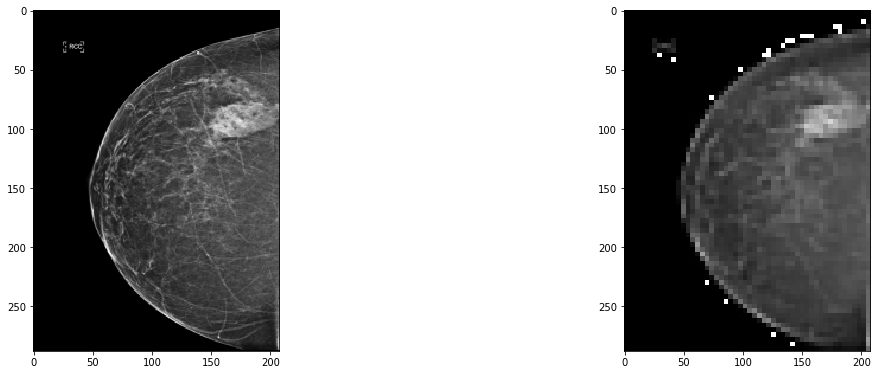

In [57]:

test = pd.read_csv("breast_density_dataset/test.csv")

image_uid=test.values[2,0]
image_file = os.path.join(TEST_DIR, image_uid + ".h5")
X, breast_mask = read_image_and_breast_mask(image_file)
image = (X - X.min()) / (X.max() - X.min())*255.
image=image.astype('uint8')
rec= autoencoder.predict(image.reshape(1,288,208,1)).reshape(288,208)


plt.figure(figsize=(15, 20))
plt.subplot(131)
plt.imshow((image).astype('uint8'), cmap='gray')
plt.subplot(133)
plt.imshow((rec).astype('uint8'), cmap='gray')
plt.show()